# Multilabel classification on PASCAL using python data-layers

In this tutorial we will do multilabel classification on PASCAL VOC 2012.

Multilabel classification is a generalization of multiclass classification, where each instance (image) can belong to many classes. For example, an image may both belong to a "beach" category and a "vacation pictures" category. In multiclass classification, on the other hand, each image belongs to a single class.

Caffe supports multilabel classification through the SigmoidCrossEntropyLoss layer, and we will load data using a Python data layer. Data could also be provided through HDF5 or LMDB data layers, but the python data layer provides endless flexibility, so that's what we will use.

### 1. Preliminaries

* First, make sure you compile caffe using
WITH_PYTHON_LAYER := 1

* Second, download PASCAL VOC 2012. It's available here: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html

* Third, import modules:

In [1]:
import sys 
import os

import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

from copy import copy

% matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.append(caffe_root + 'python')
import caffe # If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

from caffe import layers as L, params as P # Shortcuts to define the net prototxt.
sys.path.append("pycaffe/layers") # the datalayers we will use are in this directory.
sys.path.append("pycaffe") # the tools file is in this folder

import tools #this contains some tools that we need

* Fourth, set data directories and initialize caffe

In [2]:
# set data root directory, e.g:
pascal_root = osp.join(caffe_root, 'data/pascal/VOC2012')

# these are the PASCAL classes, we'll need them later.
classes = np.asarray(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'])
from IPython.core.debugger import Tracer
# make sure we have the caffenet weight downloaded.
if not os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

# initialize caffe for gpu mode
#caffe.set_mode_gpu()
#caffe.set_device(0)

### 2. Define network prototxts

* Let's start by defining the nets using caffe.NetSpec. Note how we used the SigmoidCrossEntropyLoss layer. This is the right loss for multilabel classification. Also note how the data layer is defined.

### 3. Write nets and solver files

* Now we can crete net and solver prototxts. For the solver, we use the CaffeSolver class from the "tools" module

* This net uses a python datalayer: 'PascalMultilabelDataLayerSync', which is defined in './pycaffe/layers/pascal_multilabel_datalayers.py'. 

* Take a look at the code. It's quite straight-forward, and gives you full control over data and labels.

* Now we can load the caffe solver as usual.

In [3]:
workdir = './pascal_multilabel_with_datalayer'
solver = caffe.SGDSolver(osp.join(workdir, 'solver.prototxt'))
solver.net.copy_from(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
solver.test_nets[0].share_with(solver.net)
#solver.step(1)caxuer

BatchLoader initialized with 5717 images
PascalMultilabelDataLayerSync initialized for split: train, with bs: 128, im_shape: [227, 227].
BatchLoader initialized with 5823 images
PascalMultilabelDataLayerSync initialized for split: val, with bs: 128, im_shape: [227, 227].


* Let's check the data we have loaded.

In [4]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

* NOTE: we are readin the image from the data layer, so the resolution is lower than the original PASCAL image.

### 4. Train a net.

* Let's train the net. First, though, we need some way to measure the accuracy. Hamming distance is commonly used in multilabel problems. We also need a simple test loop. Let's write that down. 

In [5]:
def hamming_distance(gt, est):
    return sum([1 for (g, e) in zip(gt, est) if g == e]) / float(len(gt))

def check_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = net.blobs['score'].data > 0
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

* Alright, now let's train for a while

In [6]:
banch_size = 128
num = int(np.ceil(5823.0/128))
for itt in range(num):
    test_nets = solver.test_nets[0]
    test_nets.forward()
    feat1 = test_nets.blobs['fc6'].data
    feat2 = test_nets.blobs['fc7'].data
    labels = test_nets.blobs['label'].data.astype(np.int)
    with open('./data/valset67.csv', 'a') as f:
        feat = np.concatenate((feat1,feat2), axis=1)
        np.savetxt(f, feat, delimiter=',')
    with open('./data/vallabels67.csv', 'a') as f:
        np.savetxt(f, labels, delimiter = ',')
#vis_square(filters)

In [7]:
banch_size = 128
num = int(np.ceil(5717.0/128))
for itt in range(num):
    train_nets = solver.net
    train_nets.forward()
    feat1 = train_nets.blobs['fc6'].data
    feat2 = train_nets.blobs['fc7'].data
    labels = train_nets.blobs['label'].data.astype(np.int)
    with open('./data/trainset67.csv', 'a') as f:
        feat = np.concatenate((feat1,feat2), axis=1)
        np.savetxt(f, feat,delimiter = ',')
    with open('./data/trainlabels67.csv', 'a') as f:
        np.savetxt(f, labels,delimiter = ',')

(128, 4096)
(128, 20)


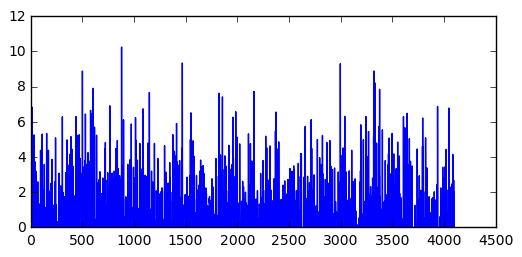

In [9]:
print feat.shape
print labels.shape
plt.subplot(2, 1, 1)
plt.plot(feat[0].flat)

In [10]:
feat

array([[ 0.        ,  0.        ,  0.32806879, ...,  2.68058586,
         0.        ,  1.99569571],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         2.55729532,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.03411531],
       ..., 
       [ 0.        ,  2.02418518,  0.        , ...,  1.11027837,
         0.40165097,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.78199732,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

* Great, the accuracy is increasing, and it seems to converge rather quickly. It may seem strange that it starts off so high but it is because the ground truth is sparse. There are 20 classes in PASCAL, and usually only one or two is present. So predicting all zeros yields rather high accuracy. Let's check to make sure.

In [ ]:
def check_baseline_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = np.zeros((batch_size, len(gts)))
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

print 'Baseline accuracy:{0:.4f}'.format(check_baseline_accuracy(solver.test_nets[0], 5823/128))

In [ ]:
solver.net.save('../models/bvlc_reference_caffenet/bvlc_reference_caffenet_voc.caffemodel')

### 6. Look at some prediction results

In [ ]:
test_net = solver.test_nets[0]
for image_index in range(5):
    plt.figure()
    plt.imshow(transformer.deprocess(copy(test_net.blobs['data'].data[image_index, ...])))
    gtlist = test_net.blobs['label'].data[image_index, ...].astype(np.int)
    estlist = test_net.blobs['score'].data[image_index, ...] > 0
    plt.title('GT: {} \n EST: {}'.format(classes[np.where(gtlist)], classes[np.where(estlist)]))
    plt.axis('off')